In [1]:
from PIL import Image
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

import seaborn as sns
import csv
import unicodedata
import numpy as np
import os
import json
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import math
import random


/home/ant/miniconda3/envs/psl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-01-23 23:24:29.876842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # Open an image file
# img = Image.open('images/A.jpg')  # Replace 'path_to_your_image.jpg' with the actual path to your image file

# # Display basic information about the image
# print(f"Image format: {img.format}")
# print(f"Image mode: {img.mode}")
# print(f"Image size: {img.size}")

# # Show the image
# img.show()
# # Display the image
# concatenated_img = np.concatenate((img, img), axis=1)

# plt.imshow(concatenated_img)
# plt.axis('off')  # Turn off axis labels
# # plt.show()
# print()

In [3]:
def fix_polish_chars(label):
    d = {
        'Ć': 'Ć',
        'Ę': 'Ę',
        'Ł': 'Ł',
        'Ń': 'Ń',
        'Ó': 'Ó',
        'Ś': 'Ś',
        'Ź': 'Ź',
        'Ż': 'Ż'
    }
    if label.upper() in d:
        label = d[label]
    # d = {ord(k): ord(v) for k, v in d.items()}
    return label#.upper().translate(d)

In [4]:
# def replace_polish_characters(label):
#########################
#     # wrong polish letters (2chars)
################################
#     label = label.upper()  # Convert to uppercase
#     # label = label.replace('Ą', 'A')
#     label = label.replace('Ć', 'C')
#     label = label.replace('P', 'E')
#     label = label.replace('SZ', 'B')
#     label = label.replace('Ę', 'E')
#     label = label.replace('CH', 'H')
#     label = label.replace('I', 'J')
#     label = label.replace('Ł', 'L')
#     label = label.replace('Ń', 'N')
#     label = label.replace('Ó', 'O')
#     label = label.replace('RZ', 'R')
#     label = label.replace('Ś', 'S')
#     label = label.replace('Ź', 'Z')
#     label = label.replace('Ż', 'Z')
#     # Add other replacements as needed

#     # Remove diacritics from remaining characters
#     label = ''.join(c for c in unicodedata.normalize('NFD', label) if unicodedata.category(c) != 'Mn')

#     return label


In [5]:
def replace_polish_characters(label):
    d = {
        'Ć': 'C',
        'P': 'E',
        'SZ': 'B',
        'Ę': 'E',
        'CH': 'H',
        'I': 'J',
        'Ł': 'L',
        'Ń': 'N',
        'Ó': 'O',
        'RZ': 'R',
        'Ś': 'S',
        'Ź': 'Z',
        'Ż': 'Z'
    }
    if label.upper() in d:
        label = d[label]
    # d = {ord(k): ord(v) for k, v in d.items()}
    return label#.upper().translate(d)

    label = label.upper()  # Convert to uppercase
    

In [6]:
def preprocess_data(labels_folder):
    labeled_with_landmarks_count = 0
    labeled_without_landmarks_count = 0
    data_rows = []
    labels = []

    for filename in tqdm(os.listdir(labels_folder)):
        if filename.endswith('.json'):
            json_path = os.path.join(labels_folder, filename)
            
            # Check if the corresponding JSON file exists
            if os.path.exists(json_path):
                with open(json_path, 'r', encoding='utf-8') as json_file:
                    data = json.load(json_file)

                    if 'hand_landmarks' in data and 'label' in data:
                        hand_landmarks = data['hand_landmarks']
                        label = data['label']

                        # Check if 'hand_landmarks' and 'label' are not empty or None
                        if hand_landmarks and label:
                            labeled_with_landmarks_count += 1

                            # Extract filename without extension
                            file_name = os.path.splitext(os.path.basename(filename))[0]

                            data_rows.append(file_name)
                            modified_label = fix_polish_chars(label)
                            labels.append(modified_label)

                        else:
                            labeled_without_landmarks_count += 1

    return labeled_with_landmarks_count, labeled_without_landmarks_count, data_rows, labels

# Load and preprocess the data
labels_folder = '../dataset/labels'
labeled_with_landmarks_count, labeled_without_landmarks_count, data_rows, labels = preprocess_data(labels_folder)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_rows, labels, test_size=0.2, random_state=42)

# Extract filenames without extensions
X_train_filenames = [os.path.splitext(filename)[0] for filename in X_train]
X_test_filenames = [os.path.splitext(filename)[0] for filename in X_test]

# Save training data to CSV
train_data_file = 'train_data.csv'
with open(train_data_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Label'])  # Add headers if needed
    for filename, label in zip(X_train_filenames, y_train):
        csvwriter.writerow([filename, label])

# Save testing data to CSV
test_data_file = 'test_data.csv'
with open(test_data_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Label'])  # Add headers if needed
    for filename, label in zip(X_test_filenames, y_test):
        csvwriter.writerow([filename, label])

100%|██████████| 3626/3626 [00:00<00:00, 12980.25it/s]


In [7]:
import csv
import json

def read_csv(file_path):
    data = []
    with open(file_path, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            data.append(row)
    return data

def load_json(file_path):
    with open(file_path, 'r') as file:
        json_data = json.load(file)
    return json_data

def process_data(csv_file, json_folder, replace=False):
    data = read_csv(csv_file)
    data_list = []
    labels = []

    for entry in data:
        filename = entry['Filename']
        label = entry['Label']
        if replace:
            label = replace_polish_characters(label)
        landmarks = []

        # Assuming the JSON files are in the format "{id}.json" in the json_folder
        json_file_path = f"{json_folder}/{filename}.json"

        try:
            json_data = load_json(json_file_path)

            # Access the label and hand_landmarks in json_data as needed
            # print(f"ID: {filename}, Label: {label}")
            # print("Hand Landmarks:")
            for landmark, values in json_data['hand_landmarks'].items():
                # print(f"{landmark}: {values}")
                landmarks.append(values['x'])
                landmarks.append(values['y'])
                landmarks.append(values['z'])

        except FileNotFoundError:
            print(f"JSON file not found for ID: {filename}")
        data_list.append(landmarks)
        labels.append(label)
    return data_list, labels

Training data on original labels with fixes

In [17]:
# Train
csv_file_path = 'train_data.csv'
json_folder_path = '/home/ant/projects/psl/dataset/labels'
train_data, train_labels = process_data(csv_file_path, json_folder_path)

# Test
csv_file_path = 'test_data.csv'
json_folder_path = '/home/ant/projects/psl/dataset/labels'
test_data, test_labels = process_data(csv_file_path, json_folder_path)

In [18]:
import functools
from sklearn.model_selection import cross_val_score

import sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. Define an objective function to be maximized.
def objective(trial, classifier_name):

    if classifier_name == 'SVC':
         C = trial.suggest_float('C', 1e-10, 1e10, log=True)
         classifier_obj =  make_pipeline(StandardScaler(), SVC(C=C))
    elif classifier_name == 'DecisionTreeClassifier':       
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        classifier_obj = DecisionTreeClassifier(max_depth=max_depth)
    elif classifier_name == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(
            C=C)
    else:
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=max_depth, n_estimators=20)
    scores = cross_val_score(
            classifier_obj, train_data, train_labels, cv=4, scoring='accuracy', n_jobs=1)
    return scores.mean()

def test_models(train_data, train_labels, test_data, test_labels):
    models = [
    ('RandomForestClassifier', RandomForestClassifier),
    ('DecisionTreeClassifier', DecisionTreeClassifier),
    ('SVC', SVC),
    ('LogisticRegression', LogisticRegression),
    ]
    for name, model in models:
        # 3. Create a study object and optimize the objective function.
        study = optuna.create_study(direction='maximize')
        study.optimize(functools.partial(objective, classifier_name=name), n_trials=20, n_jobs=-1, show_progress_bar=True)
        print(f'Best params: {study.best_params}')
        if name == 'SVC' or name == 'LogisticRegression':
            model = make_pipeline(StandardScaler(), model(**study.best_params))
        else:
            model = model(**study.best_params)
        model.fit(train_data, train_labels)
        dump(model, f'{name}.joblib') 

        # Evaluate the model
        accuracy = model.score(train_data, train_labels)
        print(f"Train Accuracy of the {name}: {accuracy}")
        accuracy = model.score(test_data, test_labels)
        print(f"Test Accuracy of the {name}: {accuracy}")

        # Confusion Matrix
        y_pred = model.predict(test_data)

        # Get class labels from the model
        class_labels = model.classes_
        
        cm = confusion_matrix(test_labels, y_pred)
        # print(f"Confusion Matrix for {name}:\n{cm}")

        # Plot Confusion Matrix
        plt.figure(figsize=(9, 9))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        # Set x-axis and y-axis tick labels
        plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45, fontsize=10)
        plt.yticks(ticks=range(len(class_labels)), labels=class_labels, rotation=0, fontsize=10)
        plt.title(f"Confusion Matrix for {name}",fontsize=14)
        plt.xlabel("Predicted Labels", fontsize=12)
        plt.ylabel("True Labels", fontsize=12)
        plt.show()

        print('-'*80)
    return study


Best trial: 17. Best value: 0.676116: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Best params: {'max_depth': 31}
Train Accuracy of the RandomForestClassifier: 1.0
Test Accuracy of the RandomForestClassifier: 0.7427258805513017


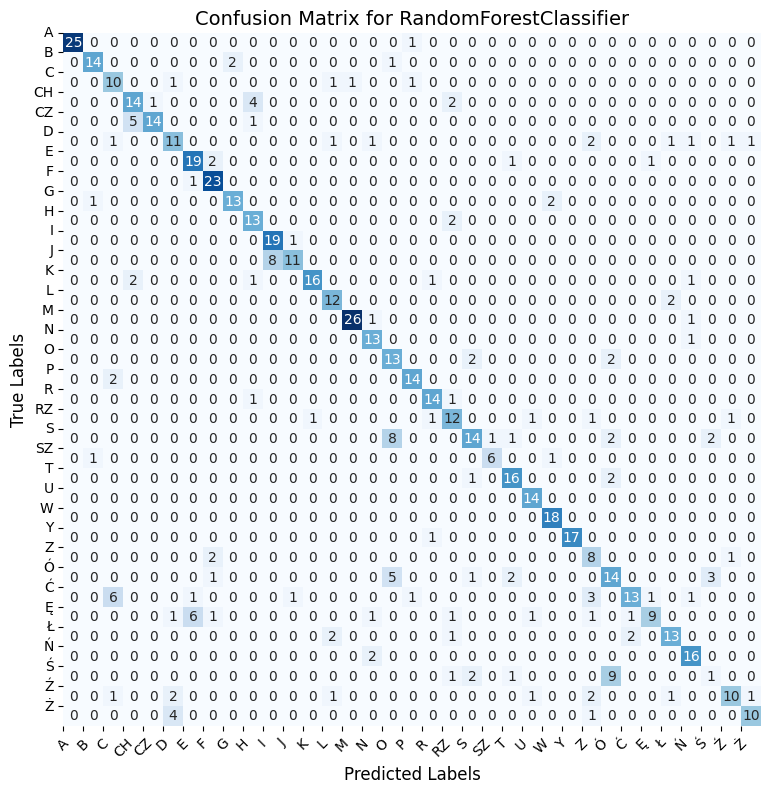

--------------------------------------------------------------------------------


Best trial: 0. Best value: 0.547338: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Best params: {'max_depth': 31}
Train Accuracy of the DecisionTreeClassifier: 1.0
Test Accuracy of the DecisionTreeClassifier: 0.5635528330781011


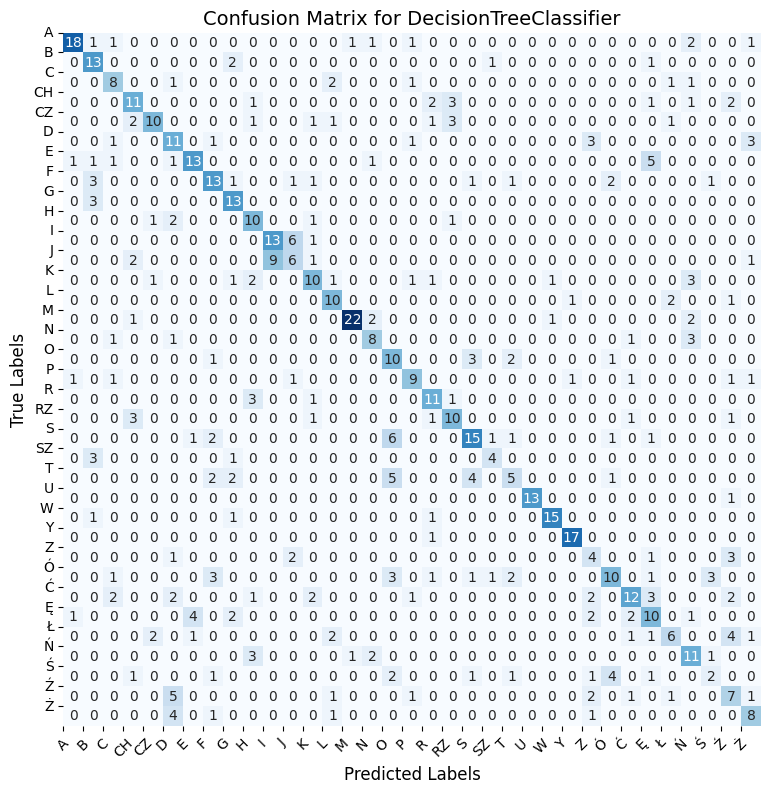

--------------------------------------------------------------------------------


Best trial: 0. Best value: 0.770408: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Best params: {'C': 457.610542588188}
Train Accuracy of the SVC: 0.9984668455346877
Test Accuracy of the SVC: 0.8070444104134763


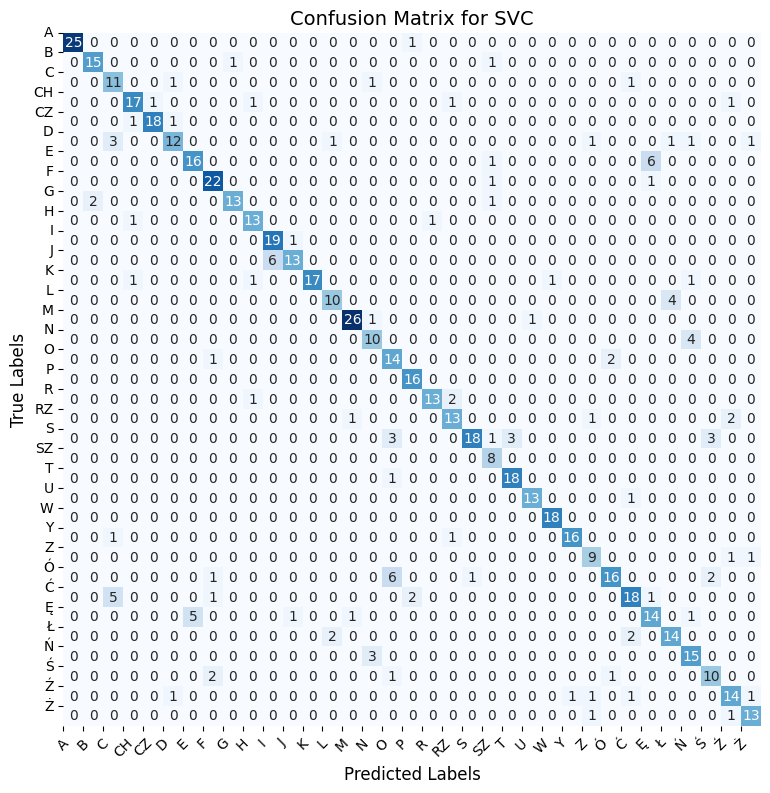

--------------------------------------------------------------------------------


Best trial: 4. Best value: 0.657736: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Best params: {'C': 5030428.5149939805}
Train Accuracy of the LogisticRegression: 0.8175546186278267
Test Accuracy of the LogisticRegression: 0.7274119448698315


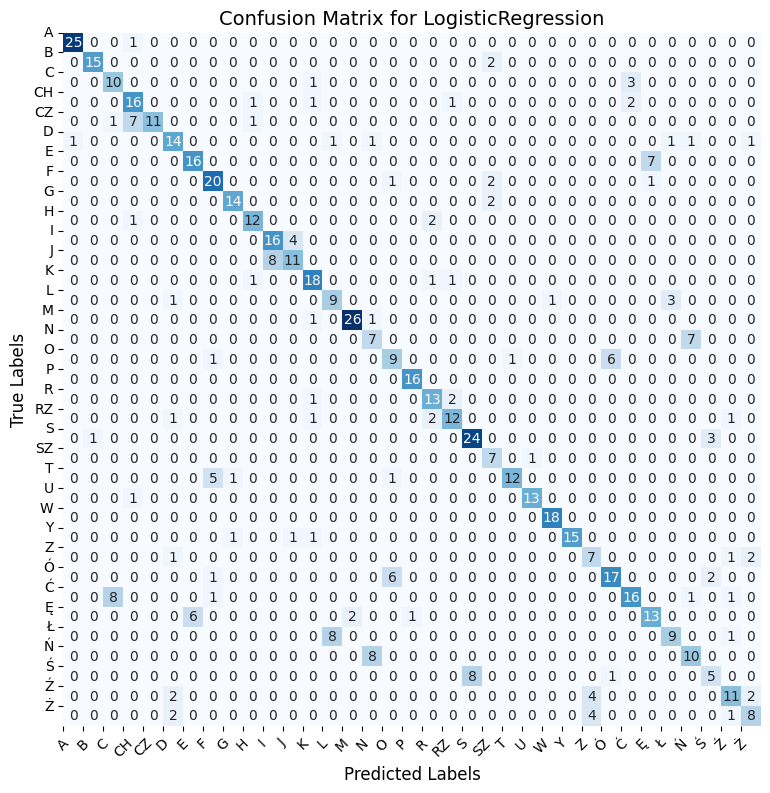

--------------------------------------------------------------------------------


In [19]:
study = test_models(train_data, train_labels, test_data, test_labels)

In [11]:
from sklearn.model_selection import cross_val_score
from joblib import dump, load

def test_models_simple(train_data, train_labels, test_data, test_labels):
    models = [
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42, max_depth=14)),
    ('SVC', make_pipeline(StandardScaler(), SVC(random_state=42))),
    # ('LogisticRegression', make_pipeline(StandardScaler(), LogisticRegression(
    #     random_state=42, max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.5))),
    ]
    for name, model in models:
        print('-'*80)
        # Train the model
        scores = cross_val_score(
            model, train_data, train_labels, cv=2, scoring='accuracy', n_jobs=-1)
        print(f"{name} {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")
        model.fit(train_data, train_labels)
        
        

        # Evaluate the model
        accuracy = model.score(train_data, train_labels)
        print(f"Train Accuracy of the {name}: {accuracy}")
        accuracy = model.score(test_data, test_labels)
        print(f"Test Accuracy of the {name}: {accuracy}")

In [12]:
test_models_simple(train_data, train_labels, test_data, test_labels)

--------------------------------------------------------------------------------


RandomForestClassifier 0.65 accuracy with a standard deviation of 0.00
Train Accuracy of the RandomForestClassifier: 1.0
Test Accuracy of the RandomForestClassifier: 0.7258805513016845
--------------------------------------------------------------------------------
DecisionTreeClassifier 0.48 accuracy with a standard deviation of 0.00
Train Accuracy of the DecisionTreeClassifier: 0.8045228056726715
Test Accuracy of the DecisionTreeClassifier: 0.5022970903522205
--------------------------------------------------------------------------------
SVC 0.55 accuracy with a standard deviation of 0.01
Train Accuracy of the SVC: 0.7428133384438482
Test Accuracy of the SVC: 0.6294027565084227


Training data on replaced labels

In [13]:
# Train
csv_file_path = 'train_data.csv'
json_folder_path = '/home/ant/projects/psl/dataset/labels'
train_data, train_labels = process_data(csv_file_path, json_folder_path, replace=True)

# Test
csv_file_path = 'test_data.csv'
json_folder_path = '/home/ant/projects/psl/dataset/labels'
test_data, test_labels = process_data(csv_file_path, json_folder_path, replace=True)

Best trial: 17. Best value: 0.779219: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Best params: {'max_depth': 28}
Train Accuracy of the RandomForestClassifier: 1.0
Test Accuracy of the RandomForestClassifier: 0.8147013782542113


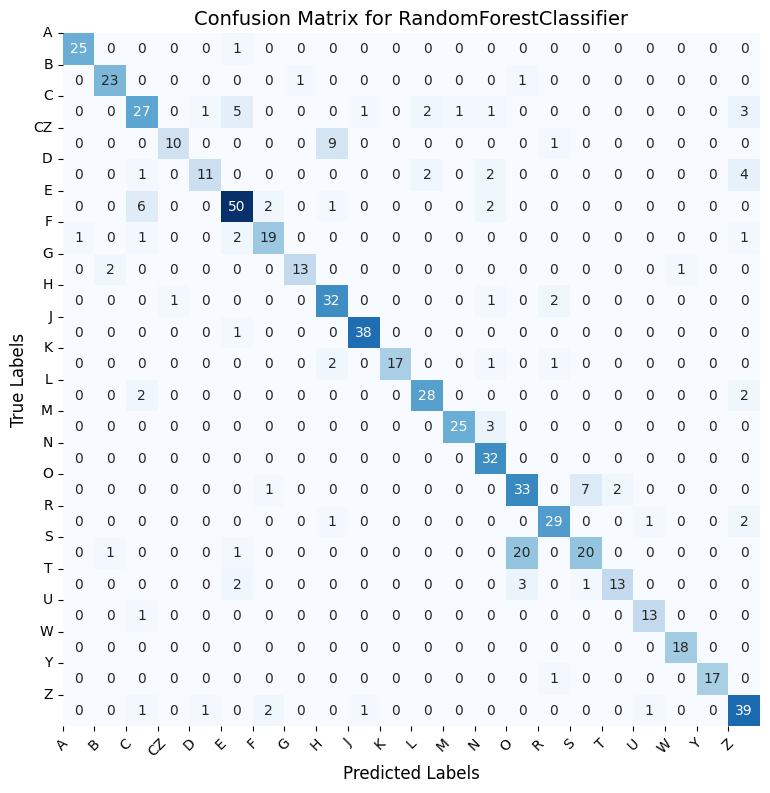

--------------------------------------------------------------------------------


Best trial: 7. Best value: 0.653891: 100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


Best params: {'max_depth': 25}
Train Accuracy of the DecisionTreeClassifier: 1.0
Test Accuracy of the DecisionTreeClassifier: 0.6738131699846861


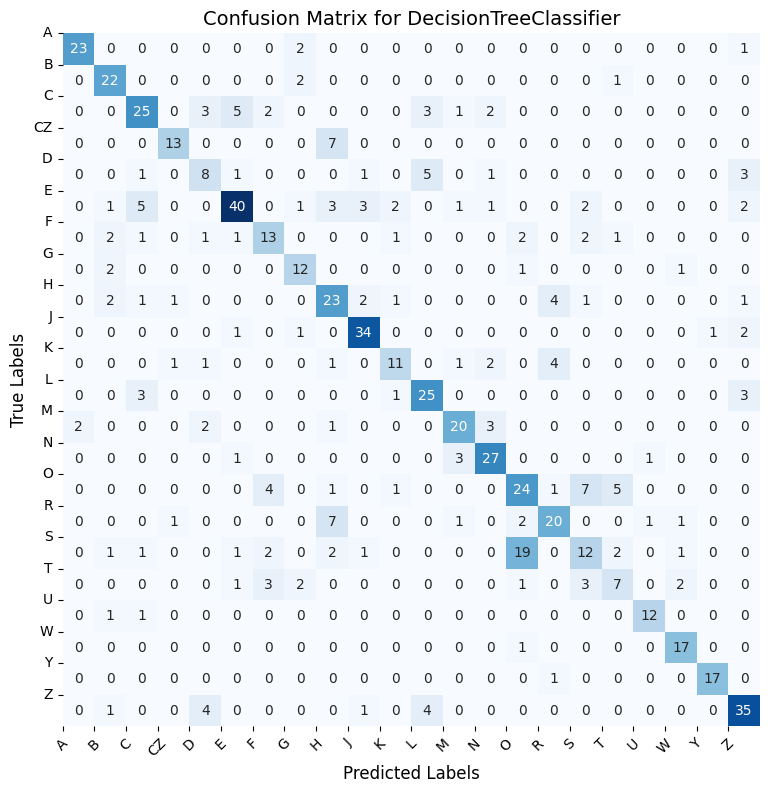

--------------------------------------------------------------------------------


Best trial: 8. Best value: 0.880792: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Best params: {'C': 381.19729966473}
Train Accuracy of the SVC: 0.9996167113836719
Test Accuracy of the SVC: 0.9050535987748851


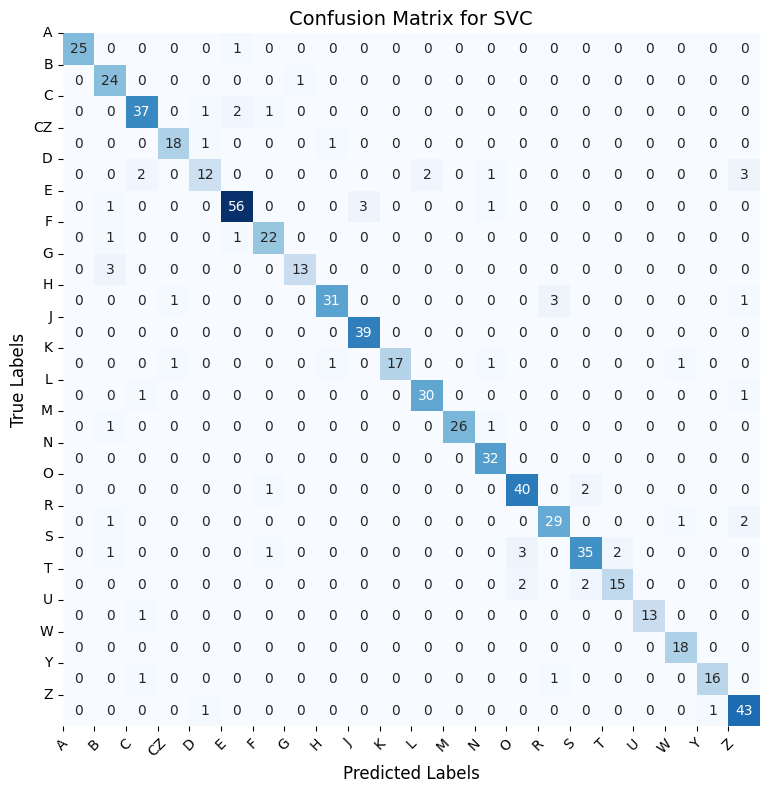

--------------------------------------------------------------------------------


Best trial: 19. Best value: 0.82254: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s] 


Best params: {'C': 170495703.30649596}
Train Accuracy of the LogisticRegression: 0.9333077807589114
Test Accuracy of the LogisticRegression: 0.8973966309341501


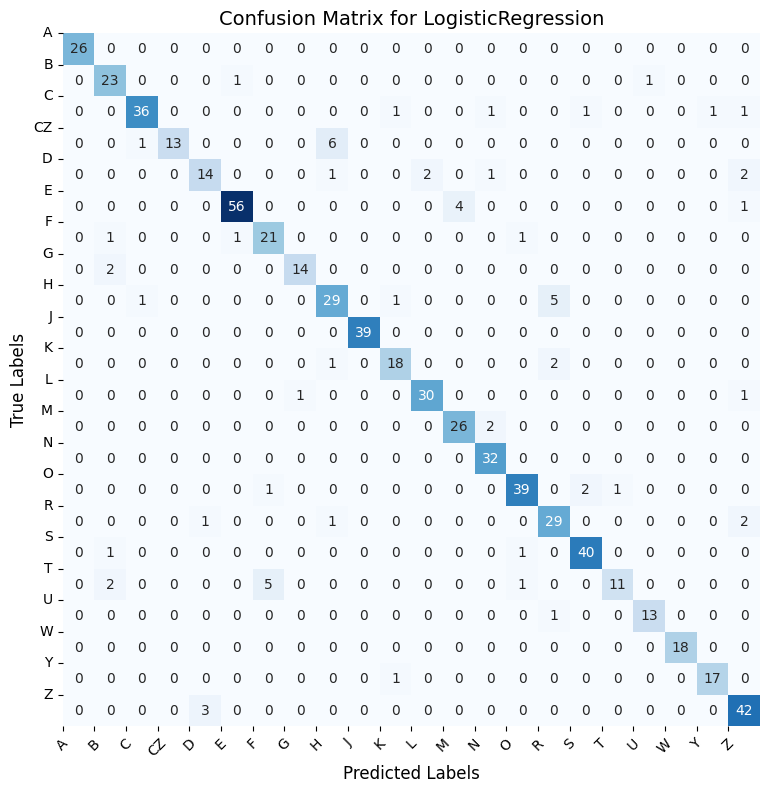

--------------------------------------------------------------------------------


In [14]:
test_models(train_data, train_labels, test_data, test_labels)

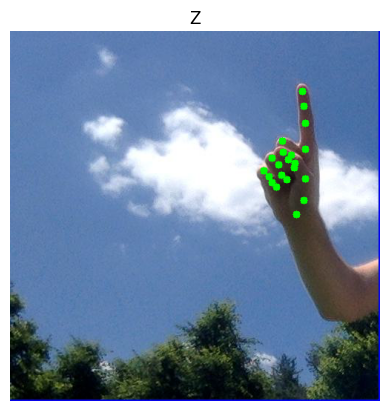

In [21]:
# Function to detect feature points and display them in the image
def detect_landmarks_draw_points(image_path):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Display of characteristic points
            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * image_rgb.shape[1]), int(landmark.y * image_rgb.shape[0])
                cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)
    
    landmarks_array = []
    for l in hand_landmarks.landmark:
        landmarks_array.append(l.x)
        landmarks_array.append(l.y)
        landmarks_array.append(l.z)
    landmarks_array = np.array(landmarks_array)

    plt.imshow(image_rgb)
    plt.title(rf.predict(landmarks_array.reshape(1, -1))[0])
    plt.show()
    return hand_landmarks.landmark

# Path to the image you wish to process
image_path = '/home/ant/projects/psl/dataset/images/Z10.jpg'

# Calling a function to detect feature points and display them on the image
landmarks = detect_landmarks_draw_points(image_path)

In [22]:
# Visualize the gesture recognition results
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    # Displays one image along with the predicted category name and score.
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(image, hand_landmarks, label):
    # Wyświetlanie punktów charakterystycznych
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks.landmark
    ])

    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        hand_landmarks_proto,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style()
    )

    plt.imshow(annotated_image)
    # Layout
    plt.title(label)
    plt.tight_layout()
    plt.show()

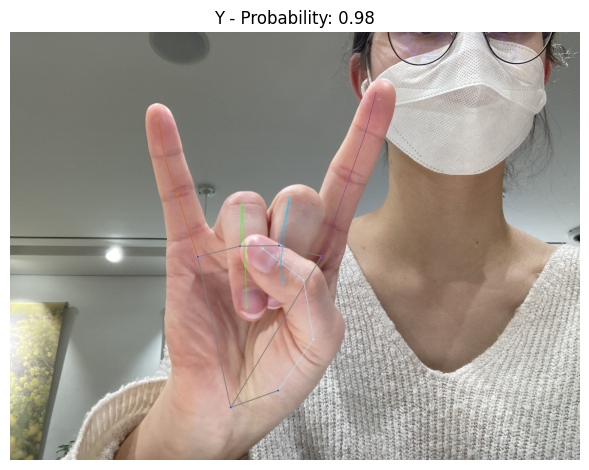

In [23]:
# Function to detect feature points and display them on the image with a connection
def detect_landmarks_draw_lines_points(image_path):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)
    # Classification
    landmarks_array = []
    for l in results.multi_hand_landmarks[0].landmark:
        landmarks_array.append(l.x)
        landmarks_array.append(l.y)
        landmarks_array.append(l.z)
    landmarks_array = np.array(landmarks_array)
    label = rf.predict(landmarks_array.reshape(1, -1))[0]
    probabilities = rf.predict_proba(landmarks_array.reshape(1, -1))[0]
    max_probability = np.max(probabilities)
    max_probability_index = np.argmax(probabilities)
    # print(probability)
    # print(type(label))

    display_batch_of_images_with_gestures_and_hand_landmarks(image_rgb, results.multi_hand_landmarks[0], f"{label} - Probability: {max_probability:.2f}")

# Path to the image you wish to process
image_path = '/home/ant/projects/psl/dataset/images/Y75.jpg'

# Calling a function to detect feature points and display them on the image
r = detect_landmarks_draw_lines_points(image_path)

In [24]:
rf.fit(X_train, y_train)

# Function to detect feature points and display them in the image
def detect_landmarks_final(image_path, selected_classes=None ):
    # Initialising MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Image loading
    image_rgb = np.array(Image.open(image_path))

    # Detection of characteristic points
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        # Classification
        landmarks_array = []
        for l in results.multi_hand_landmarks[0].landmark:
            landmarks_array.append(l.x)
            landmarks_array.append(l.y)
            landmarks_array.append(l.z)
        landmarks_array = np.array(landmarks_array)

        # Predict label and get probabilities
        label = rf.predict(landmarks_array.reshape(1, -1))[0]
        probabilities = rf.predict_proba(landmarks_array.reshape(1, -1))[0]
        max_probability = np.max(probabilities)

        # Print probabilities for each class
        for class_label, probability in zip(rf.classes_, probabilities):
            print(f"Probability for {class_label}: {probability:.2f}")

        # Display the image only for selected classes
        if selected_classes and label in selected_classes:
            # Simplified display function without hand landmarks
            plt.imshow(image_rgb)
            plt.title(f"{label} - Probability: {max_probability:.2f}")
            plt.show()
            # Return the predicted label for counting purposes
            return label
       
    else:
            print(f"No hands detected in {image_path}")
    # If no hands detected, return None
    return None


Probability for A: 0.00
Probability for B: 0.00
Probability for C: 0.00
Probability for CZ: 0.00
Probability for D: 0.01
Probability for E: 0.04
Probability for F: 0.01
Probability for G: 0.01
Probability for H: 0.17
Probability for J: 0.01
Probability for K: 0.00
Probability for L: 0.01
Probability for M: 0.00
Probability for N: 0.00
Probability for O: 0.01
Probability for R: 0.71
Probability for S: 0.00
Probability for T: 0.00
Probability for U: 0.00
Probability for W: 0.00
Probability for Y: 0.00
Probability for Z: 0.02


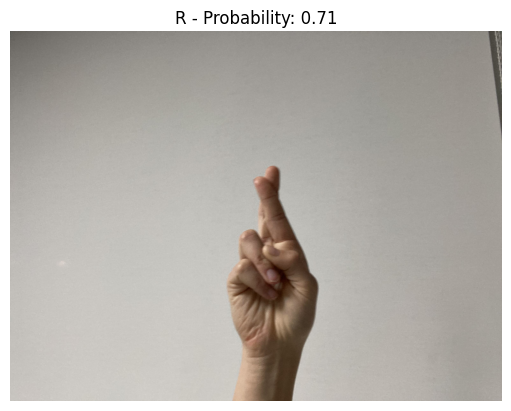

No hands detected in /home/ant/projects/psl/dataset/images/N22.jpg
No hands detected in /home/ant/projects/psl/dataset/images/L75.jpg
Probability for A: 0.00
Probability for B: 0.00
Probability for C: 0.22
Probability for CZ: 0.00
Probability for D: 0.04
Probability for E: 0.02
Probability for F: 0.00
Probability for G: 0.00
Probability for H: 0.01
Probability for J: 0.01
Probability for K: 0.01
Probability for L: 0.05
Probability for M: 0.00
Probability for N: 0.01
Probability for O: 0.00
Probability for R: 0.01
Probability for S: 0.01
Probability for T: 0.00
Probability for U: 0.00
Probability for W: 0.00
Probability for Y: 0.00
Probability for Z: 0.61
Probability for A: 0.00
Probability for B: 0.01
Probability for C: 0.01
Probability for CZ: 0.00
Probability for D: 0.03
Probability for E: 0.00
Probability for F: 0.01
Probability for G: 0.00
Probability for H: 0.02
Probability for J: 0.02
Probability for K: 0.00
Probability for L: 0.02
Probability for M: 0.00
Probability for N: 0.01


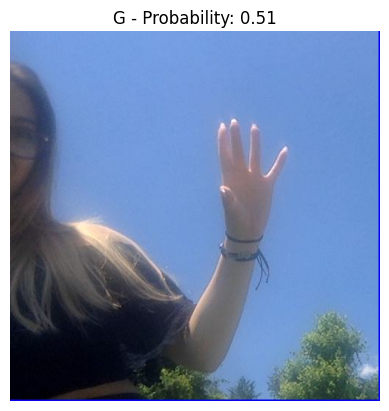

In [25]:
# Modify the function to accept selected_classes argument and count argument
def detect_landmarks_for_all_images(images_path, selected_classes=None, count_per_class=1):
    class_image_count = {}

    for filename in os.listdir(images_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(images_path, filename)
            label = detect_landmarks_final(image_path, selected_classes)

            if label:
                # Count the number of images displayed for each class
                class_image_count[label] = class_image_count.get(label, 0) + 1

                # Stop displaying images for a class after reaching the specified count
                if class_image_count.get(label, 0) >= count_per_class:
                    selected_classes.remove(label)

                # Stop processing images once one image per class has been displayed for all selected classes
                if not selected_classes:
                    break

# Path to the image you wish to process
images_path = '/home/ant/projects/psl/dataset/images/'


# Get 2 random classes from the RandomForestClassifier classes
random_classes = random.sample(rf.classes_.tolist(), 2)

# Convert random_classes to a set to use the discard method
random_classes_set = set(random_classes)

# Set the count of images to display per class
count_per_class = 1

# Calling a function to detect feature points and display one image per class for the selected classes
detect_landmarks_for_all_images(images_path, selected_classes=random_classes, count_per_class=count_per_class)